# Engenharia de Atributos

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [180]:
merged_dataset = pd.read_csv('../data/processed/merged_dataset.csv')

In [181]:
merged_dataset.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR',
       'NO_FUNCIONARIOS', 'DATA_CADASTRO', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'DIAS_ATRASO',
       'TARGET_INADIMPLENCIA', 'DIAS_ADIANTAMENTO'],
      dtype='object')

## Convertendo as variáveis para os seus tipos corretos 

In [182]:
# Conversão dos tipos numéricos e categóricos
merged_dataset = merged_dataset.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int', 
    'DIAS_ATRASO': 'Int64',
    'TARGET_INADIMPLENCIA': 'int',
    'SEGMENTO_INDUSTRIAL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
    'DIAS_ADIANTAMENTO': 'int',
    'DOMINIO_EMAIL': 'category',
})

# Conversão de datas
merged_dataset['SAFRA_REF'] = pd.to_datetime(
    merged_dataset['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    merged_dataset['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_PAGAMENTO'] = pd.to_datetime(
    merged_dataset['DATA_PAGAMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_VENCIMENTO'] = pd.to_datetime(
    merged_dataset['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_CADASTRO'] = pd.to_datetime(
    merged_dataset['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)


In [183]:
merged_dataset.dtypes

ID_CLIENTE                         int64
SAFRA_REF                 datetime64[ns]
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                    int64
DATA_CADASTRO             datetime64[ns]
FLAG_PF                            int32
SEGMENTO_INDUSTRIAL             category
DOMINIO_EMAIL                   category
PORTE                           category
CEP_2_DIG                       category
DIAS_ATRASO                        Int64
TARGET_INADIMPLENCIA               int32
DIAS_ADIANTAMENTO                  int32
dtype: object

## Criando novas features

Calculando tempo de casa. Indica a relação dos clientes com a empresa, isso pode influenciar na inadimplência. Clientes mais velhos de casa têm menos tendência a inadimplência.

In [184]:
merged_dataset['TEMPO_CADASTRO_PARA_VENCIMENTO'] = (merged_dataset['DATA_VENCIMENTO'] - merged_dataset['DATA_CADASTRO']).dt.days

In [185]:
merged_dataset['TEMPO_DE_CASA_MESES'] = merged_dataset['TEMPO_CADASTRO_PARA_VENCIMENTO'] // 30


In [186]:
merged_dataset = merged_dataset.drop(columns='TEMPO_CADASTRO_PARA_VENCIMENTO')


Prazo para o pagamento: ajuda a entender o tempo que o cliente teve para se preparar para o pagamento. Prazos curtos podem influenciar na inadimplência.



In [187]:
merged_dataset['PRAZO_PAGAMENTO_DIAS'] = (merged_dataset['DATA_VENCIMENTO'] - merged_dataset['DATA_EMISSAO_DOCUMENTO']).dt.days

Criando variável para capturar a sazonalidade. Capturar a sazonalidade em problemas de inadimplência é importante porque o comportamento de pagamento dos clientes pode variar ao longo do ano devido a fatores como 13º salário, impostos, datas comemorativas e ciclos de renda em determinados setores. Esses elementos influenciam diretamente a capacidade de pagamento e o risco de inadimplência. Além disso, incluir variáveis sazonais, como o mês de referência da transação, ajuda o modelo a reconhecer padrões temporais recorrentes, melhorando sua capacidade preditiva.

In [188]:
merged_dataset['MES_SAFRA'] = merged_dataset['SAFRA_REF'].dt.month

 Criação de **INADIMPLENCIAS\_ANTERIORES**. Essa variável é um contador cumulativo do número de inadimplências passadas para cada cliente até o momento do pagamento atual. Ela captura o comportamento passado do cliente, que é um forte indicador de risco de inadimplência. Clientes reincidentes tendem a ter maior probabilidade de inadimplir novamente. Para evitar **data leakage**, a contagem considera apenas as inadimplências anteriores à linha atual, utilizando o deslocamento dos valores (shift) antes do cálculo acumulado (cumsum). Dessa forma, garantimos que o modelo não tenha acesso a informações futuras no momento da previsão.


In [189]:
# Ordena por cliente e data de emissão
merged_dataset = merged_dataset.sort_values(by=['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO'])

merged_dataset['INADIMPLENCIAS_ANTERIORES'] = (
    merged_dataset
    .groupby('ID_CLIENTE')['TARGET_INADIMPLENCIA']
    .shift(fill_value=0)  # desloca a inadimplência para não pegar a atual (evita data leakage)
    .groupby(merged_dataset['ID_CLIENTE'])
    .cumsum()
)

# colocando um limite para essa abordagem para não prejudicar o modelo como um todo 
merged_dataset['INADIMPLENCIAS_ANTERIORES']=merged_dataset['INADIMPLENCIAS_ANTERIORES'].clip(upper=15)

A consulta a seguir mostra que a estratégia funcionou de maneira adequada e a feature foi criada de maneira correta

In [190]:
merged_dataset[merged_dataset['ID_CLIENTE']==43266641219008038][['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'TARGET_INADIMPLENCIA', 'INADIMPLENCIAS_ANTERIORES']]


,ID_CLIENTE,DATA_EMISSAO_DOCUMENTO,TARGET_INADIMPLENCIA,INADIMPLENCIAS_ANTERIORES
309,43266641219008038,2020-02-24,1,0
310,43266641219008038,2020-02-25,1,1
311,43266641219008038,2020-03-01,1,2
312,43266641219008038,2020-03-03,1,3
313,43266641219008038,2020-03-06,1,4
314,43266641219008038,2020-03-15,1,5
315,43266641219008038,2020-03-15,1,6
316,43266641219008038,2020-03-15,1,7
317,43266641219008038,2020-07-02,1,8


Criação da coluna ADIANTAMENTOS_ANTERIORES. Usar o histórico de adiantamentos como feature pode ser útil em modelos de inadimplência, pois clientes que pagam antes do vencimento tendem a apresentar menor risco, revelando disciplina financeira e previsibilidade de caixa. Para evitar **data leakage**, a contagem considera apenas os pagamentos realizados antes da data da cobrança analisada, sem utilizar informações futuras que estariam indisponíveis no momento da previsão.


In [191]:
# criação de coluna temporarea para armazenar os adiantamentos 
merged_dataset['HOUVE_ADIANTAMENTO'] = (merged_dataset['DIAS_ADIANTAMENTO'] >= 1).astype(int)

merged_dataset['ADIANTAMENTOS_ANTERIORES'] = (
    merged_dataset
    .groupby('ID_CLIENTE')['HOUVE_ADIANTAMENTO']
    .shift(fill_value=0)  # desloca a inadimplência para não pegar a atual (evita data leakage)
    .groupby(merged_dataset['ID_CLIENTE'])
    .cumsum()
)

merged_dataset['ADIANTAMENTOS_ANTERIORES']=merged_dataset['ADIANTAMENTOS_ANTERIORES'].clip(upper=15)

merged_dataset = merged_dataset.drop(columns='HOUVE_ADIANTAMENTO')

Conferindo a criação da feature. Feature funcionou de maneira adequada

In [192]:
merged_dataset[merged_dataset['ID_CLIENTE']==8784237149961904][['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'TARGET_INADIMPLENCIA','DIAS_ADIANTAMENTO',  'ADIANTAMENTOS_ANTERIORES']]

,ID_CLIENTE,DATA_EMISSAO_DOCUMENTO,TARGET_INADIMPLENCIA,DIAS_ADIANTAMENTO,ADIANTAMENTOS_ANTERIORES
0,8784237149961904,2018-09-04,0,0,0
1,8784237149961904,2018-09-06,0,0,0
2,8784237149961904,2018-09-09,0,0,0
3,8784237149961904,2018-09-11,0,0,0
4,8784237149961904,2018-09-17,0,0,0
...,...,...,...,...,...
231,8784237149961904,2021-06-10,0,0,5
232,8784237149961904,2021-06-11,0,0,5
233,8784237149961904,2021-06-12,0,0,5
234,8784237149961904,2021-06-14,0,0,5


In [193]:
merged_dataset['ADIANTAMENTOS_ANTERIORES']

merged_dataset.sort_values(by='ADIANTAMENTOS_ANTERIORES', ascending=False)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,PORTE,CEP_2_DIG,DIAS_ATRASO,TARGET_INADIMPLENCIA,DIAS_ADIANTAMENTO,TEMPO_DE_CASA_MESES,PRAZO_PAGAMENTO_DIAS,MES_SAFRA,INADIMPLENCIAS_ANTERIORES,ADIANTAMENTOS_ANTERIORES
54577,6964108750473070287,2019-11-01,2019-11-13,2019-12-19,2019-12-19,49605.00,6.99,205244.0,106,2000-08-15,...,MEDIO,42,0,0,0,235,36,11,1,15
26370,3355881107559250653,2020-11-01,2020-11-17,2020-12-03,2020-12-03,22112.00,5.99,82636.0,117,2011-02-14,...,GRANDE,32,0,0,0,119,16,11,1,15
26356,3355881107559250653,2020-10-01,2020-10-19,2020-11-04,2020-11-04,16837.05,6.99,253973.0,110,2011-02-14,...,GRANDE,32,0,0,0,118,16,10,1,15
26357,3355881107559250653,2020-10-01,2020-10-19,2020-11-03,2020-11-04,27790.00,6.99,253973.0,110,2011-02-14,...,GRANDE,32,0,0,1,118,16,10,1,15
26358,3355881107559250653,2020-10-01,2020-10-20,2020-11-06,2020-11-06,13945.01,6.99,253973.0,110,2011-02-14,...,GRANDE,32,0,0,0,118,17,10,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35936,4724876423989598202,2018-10-01,2018-10-02,2018-11-05,2018-11-05,1341.00,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,94,34,10,0,0
35937,4724876423989598202,2018-10-01,2018-10-04,2018-10-22,2018-10-22,13985.10,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,93,18,10,0,0
35938,4724876423989598202,2018-10-01,2018-10-09,2018-10-29,2018-10-29,36257.34,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,93,20,10,0,0
35939,4724876423989598202,2018-10-01,2018-10-09,2018-10-29,2018-10-29,13935.12,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,93,20,10,0,0


Selecionando uma amostra para conferir se o que eu fiz funcionou corretamente 

In [194]:
merged_dataset[merged_dataset['ID_CLIENTE']==8784237149961904][['DATA_EMISSAO_DOCUMENTO','DATA_VENCIMENTO','DATA_PAGAMENTO','DIAS_ADIANTAMENTO', 'ADIANTAMENTOS_ANTERIORES', 'INADIMPLENCIAS_ANTERIORES', 'TARGET_INADIMPLENCIA']]

,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,DATA_PAGAMENTO,DIAS_ADIANTAMENTO,ADIANTAMENTOS_ANTERIORES,INADIMPLENCIAS_ANTERIORES,TARGET_INADIMPLENCIA
0,2018-09-04,2018-09-24,2018-09-24,0,0,0,0
1,2018-09-06,2018-09-24,2018-09-24,0,0,0,0
2,2018-09-09,2018-09-25,2018-09-25,0,0,0,0
3,2018-09-11,2018-09-27,2018-09-27,0,0,0,0
4,2018-09-17,2018-10-03,2018-10-03,0,0,0,0
...,...,...,...,...,...,...,...
231,2021-06-10,2021-06-28,2021-06-28,0,5,1,0
232,2021-06-11,2021-07-01,2021-07-01,0,5,1,0
233,2021-06-12,2021-06-29,2021-06-29,0,5,1,0
234,2021-06-14,2021-06-30,2021-06-30,0,5,1,0


## Correlação da features 

In [195]:
merged_dataset.dtypes

ID_CLIENTE                            int64
SAFRA_REF                    datetime64[ns]
DATA_EMISSAO_DOCUMENTO       datetime64[ns]
DATA_PAGAMENTO               datetime64[ns]
DATA_VENCIMENTO              datetime64[ns]
VALOR_A_PAGAR                       float64
TAXA                                float64
RENDA_MES_ANTERIOR                  float64
NO_FUNCIONARIOS                       int64
DATA_CADASTRO                datetime64[ns]
FLAG_PF                               int32
SEGMENTO_INDUSTRIAL                category
DOMINIO_EMAIL                      category
PORTE                              category
CEP_2_DIG                          category
DIAS_ATRASO                           Int64
TARGET_INADIMPLENCIA                  int32
DIAS_ADIANTAMENTO                     int32
TEMPO_DE_CASA_MESES                   int64
PRAZO_PAGAMENTO_DIAS                  int64
MES_SAFRA                             int32
INADIMPLENCIAS_ANTERIORES             int32
ADIANTAMENTOS_ANTERIORES        

### Correlação das features entre si 

A matriz de correlação revela que as variáveis mais associadas à inadimplência são **DIAS_ATRASO** (0.46), **INADIMPLENCIAS_ANTERIORES** (0.36) e **PRAZO_PAGAMENTO_DIAS** (0.36), indicando que atrasos e histórico de inadimplência aumentam o risco atual. Houve uma correlação extremamente alta entre **DIAS_ADIANTAMENTO** e **PRAZO_PAGAMENTO_DIAS** (0.88), sugerindo possível redundância mas especificamente a variável **DIAS_ADIANTAMENTO** não entrará no modelo. A variável **FLAG_PF**, que indica pessoa física, apresentou correlação negativa com **NO_FUNCIONARIOS** (-0.30), que faz muito sentido já que pessoas jurídicas tendem a ter mais funcionários. Variáveis como **TAXA**, **VALOR_A_PAGAR**, **RENDA_MES_ANTERIOR** e **MES_SAFRA** não apresentaram correlações lineares relevantes, mas ainda podem ser úteis em modelos não lineares. 

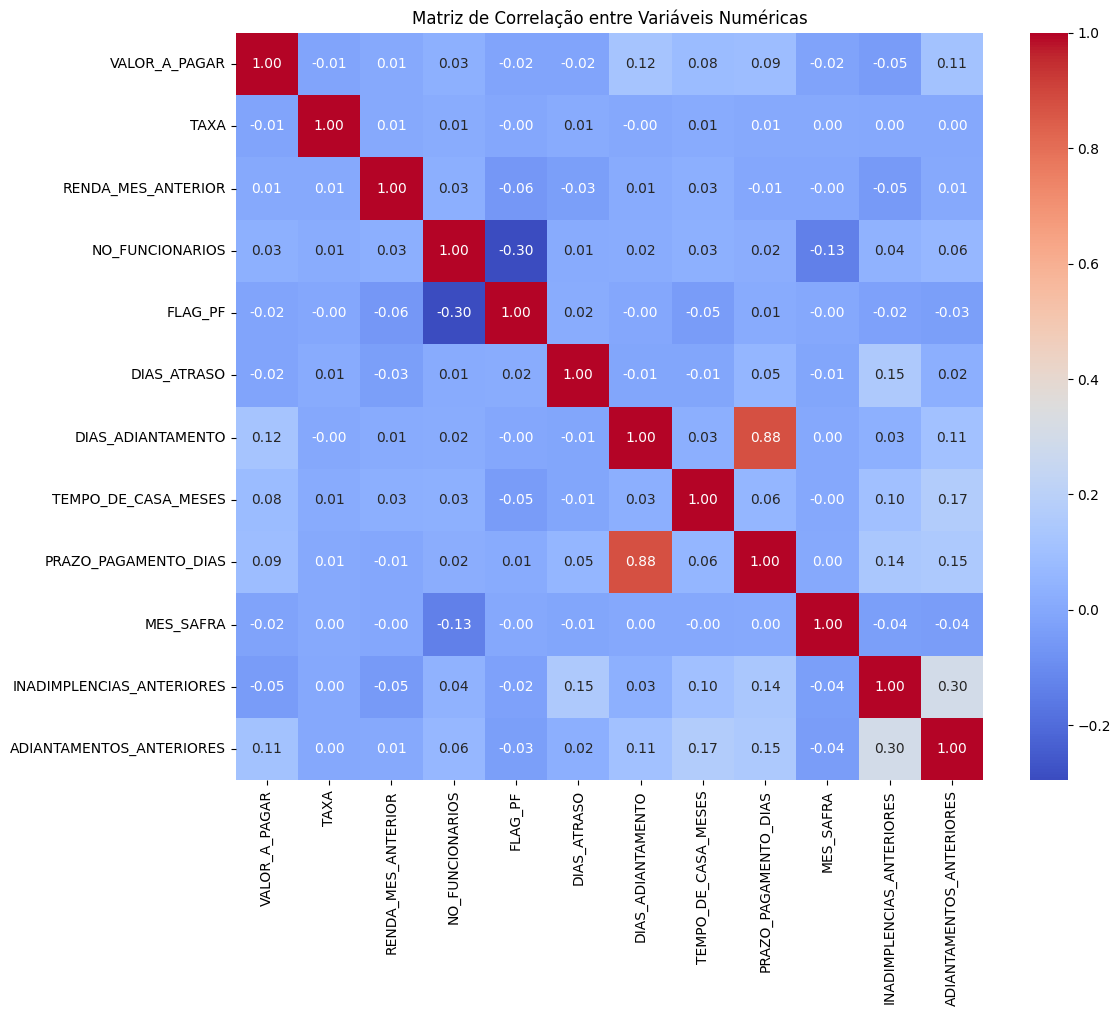

In [196]:
colunas_correlacao = [
    'VALOR_A_PAGAR',
    'TAXA',
    'RENDA_MES_ANTERIOR',
    'NO_FUNCIONARIOS',
    'FLAG_PF',
    'DIAS_ATRASO', # Não entrará no modelo para não ter data leackage e consequentemente overfitting
    #'TARGET_INADIMPLENCIA',
    'DIAS_ADIANTAMENTO', # Não entrará no modelo para não ter data leackage e consequentemente overfitting
    'TEMPO_DE_CASA_MESES',
    'PRAZO_PAGAMENTO_DIAS',
    'MES_SAFRA',
    'INADIMPLENCIAS_ANTERIORES',
    'ADIANTAMENTOS_ANTERIORES'
]

# Filtra apenas as colunas relevantes
df_numerico = merged_dataset[colunas_correlacao]

# Calcula a matriz de correlação de Pearson
matriz_correlacao = df_numerico.corr(method='pearson')

# Plot da matriz com Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

### Correlação com a variável target

Ao analisar a correlação entre as variáveis numéricas e o meu target **TARGET_INADIMPLENCIA**, percebo que **DIAS_ATRASO** é a variável com maior correlação positiva, o que era esperado, já que atrasos tendem a estar diretamente ligados à inadimplência. Em seguida, **INADIMPLENCIAS_ANTERIORES** também mostra uma correlação relevante, sugerindo que o histórico de inadimplência é um forte indicativo de recorrência. **PRAZO_PAGAMENTO_DIAS** aparece como outro fator associado positivamente, talvez indicando que prazos mais longos aumentem o risco. Por outro lado, variáveis como **VALOR_A_PAGAR** e **RENDA_MES_ANTERIOR** apresentam correlação negativa moderada, sugerindo que valores mais altos de pagamento ou renda estejam associados a um menor risco. Algumas variáveis como **TAXA** e **ADIANTAMENTOS_ANTERIORES** têm correlação praticamente nula, o que indica que não contribuem diretamente para a explicação da inadimplência.

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18584\1095478721.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='coolwarm')


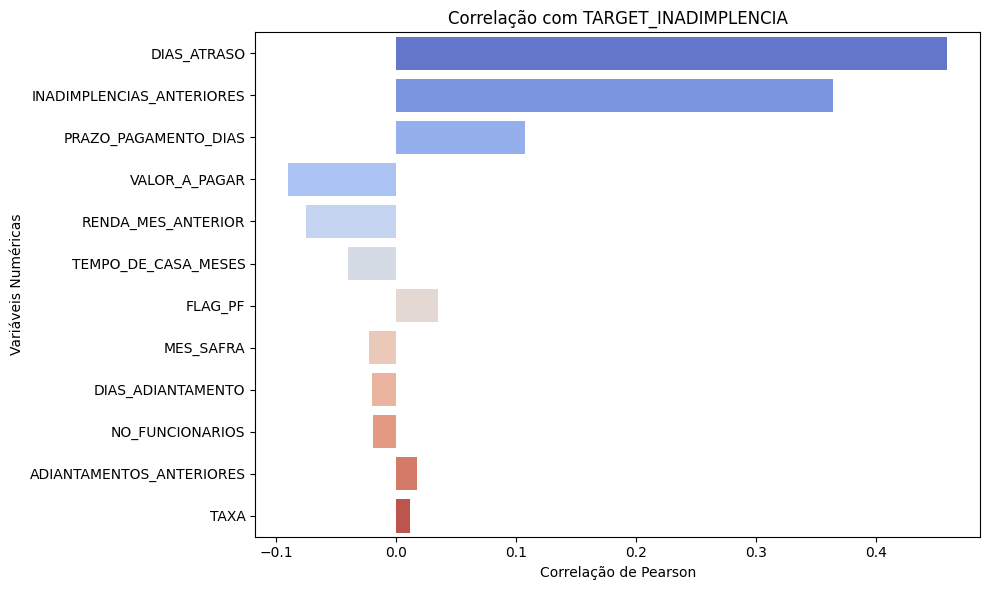

In [197]:
# Seleciona as colunas numéricas
numericas = merged_dataset.select_dtypes(include=['int64', 'float64', 'int32'])

numericas = numericas.drop(columns=['ID_CLIENTE'])
# Calcula correlação com a variável alvo
correlacoes = numericas.corr()['TARGET_INADIMPLENCIA'].drop('TARGET_INADIMPLENCIA')

# Ordena por correlação absoluta
correlacoes = correlacoes.reindex(correlacoes.abs().sort_values(ascending=False).index)

# Plota gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='coolwarm')
plt.title('Correlação com TARGET_INADIMPLENCIA')
plt.xlabel('Correlação de Pearson')
plt.ylabel('Variáveis Numéricas')
plt.tight_layout()
plt.show()


In [198]:
merged_dataset.to_csv('../data/processed/dataset_features_v1.csv', index=False)